In [22]:
import xarray as xr

In [28]:
db = xr.open_dataset('./data/S5P_OFFL_L2__HCHO___20220319T235012_20220320T013142_22964_02_020300_20220321T154523.nc', group='PRODUCT')
db.to_zarr('./data_cleaned/S5P_OFFL_L2__HCHO___20220319T235012_20220320T013142_22964_02_020300_20220321T154523.zarr', mode='w')



In [24]:
methane_corrected = db['methane_mixing_ratio_bias_corrected'][0,:,:]
lat = methane_corrected.latitude
lon = methane_corrected.longitude

In [14]:
qa = db['qa_value'][0,:,:]

In [15]:
methane_corrected_masked = methane_corrected.where(qa>0.5)

In [16]:
methane_corrected_masked.shape

(4172, 215)

In [17]:
methane_corrected_masked.values


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [25]:
methane_corrected.values.max()
lat

<xarray.DataArray 'latitude' (scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2022-03-14
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

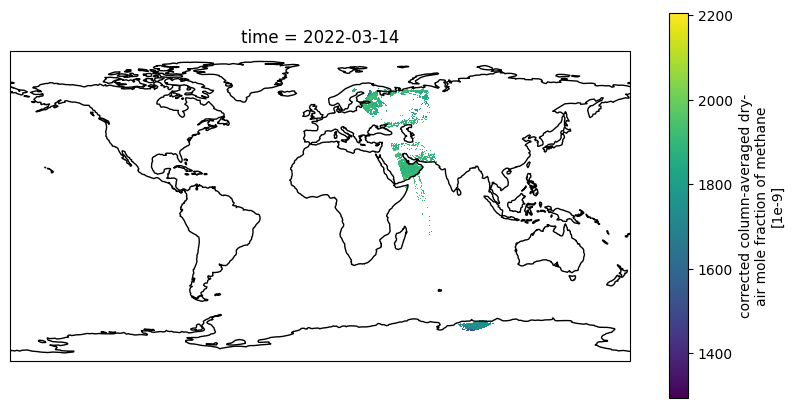

In [26]:
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

db.methane_mixing_ratio_bias_corrected[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True)

ax.set_global(); ax.coastlines()
plt.show()

In [1]:
import glob
import os
from sentinel5dl import search, download
import multiprocessing
import xarray as xr


def main():
    products = [
                'L2__CH4___',
                'L2__CO____',
                'L2__HCHO__',
                'L2__NO2___',
                'L2__O3____',
                'L2__SO2___'
                ]
    begin = '2023-05-14T00:00:00.000Z'
    end = '2023-05-15T23:59:59.999Z'
    output_dir = './data'
    db_path = './db'

    for pro in products:
        result = search(
            begin_ts=begin,
            end_ts=end,
            product=pro,
            processing_level='L2',
            processing_mode='Offline'
        )
        print("debug")
        with multiprocessing.Pool(10) as pool:
            pool.starmap(download, map(
                 lambda product: ((product,), output_dir),
                 result.get('products')
             ))

        files = glob.glob(output_dir + '/*.nc')

        to_database(first=True, file=files[0], db_path=db_path, product=pro+"TIME")

        for file in files:
            if file == files[0]:
                continue
            to_database(first=False, file=file, db_path=db_path, product=pro+"TIME")


def to_database(first: bool, file: str, db_path: str, product: str) -> None:
    timestep_db = xr.open_dataset(file, group='PRODUCT')
    if first:
        timestep_db.to_zarr(os.path.join(db_path, product), mode='w', consolidated=True)
    else:
        timestep_db.to_zarr(os.path.join(db_path, product), mode='a', consolidated=True, append_dim='time')

In [2]:
main()

debug


ValueError: variable 'delta_time' already exists with different dimension sizes: {'scanline': 4173} != {'scanline': 4172}. to_zarr() only supports changing dimension sizes when explicitly appending, but append_dim='time'.

In [4]:
dbs = xr.open_mfdataset('./data/*.nc', parallel=True, concat_dim='time', combine='nested', group='PRODUCT')


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 4:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object not 

In [5]:
print(dbs)

<xarray.Dataset>
Dimensions:                              (scanline: 4174, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 27)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.173e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-05-14 ......
    latitude                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 215), meta=np.ndarray>
    longitude                            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 215), meta=np.ndarray>
Data variables:
    delta_tim

In [1]:
import xarray as xr

db = xr.open_zarr('./db/L2__HCHO__.zarr')
db

/home/def/Backup/Uni/Magistrale/1/Second semester/Air-Quality-Monitoring-Platform/venv/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                                              (corner: 4, time: 240,
                                                          scanline: 4174,
                                                          ground_pixel: 450,
                                                          layer: 34)
Coordinates:
  * corner                                               (corner) float64 0.0...
  * ground_pixel                                         (ground_pixel) float64 ...
  * layer                                                (layer) int32 0 ... 33
  * scanline                                             (scanline) float64 0...
  * time                                                 (time) datetime64[ns] ...
Data variables:
    delta_time                                           (time, scanline, ground_pixel) datetime64[ns] dask.array<chunksize=(30, 522, 57), meta=np.ndarray>
    formaldehyde_tropospheric_vertical_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 450), meta=np.ndarray>
    formaldehyde_tropospheric_vertical_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 450), meta=np.ndarray>
    latitude                                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 450), meta=np.ndarray>
    longitude                                            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 450), meta=np.ndarray>
    qa_value                                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4174, 450), meta=np.ndarray>
    time_utc                                             (time, scanline) float64 dask.array<chunksize=(1, 4174), meta=np.ndarray>